In [1]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import random
from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
pip install np_utils

     |████████████████████████████████| 61kB 7.4MB/s 
  Created wheel for np-utils: filename=np_utils-0.5.12.1-cp37-none-any.whl size=57133 sha256=8d1f8289b7b70548d9ea84f2a18b44149f4a336f1aa4bfe151b0a46ea63b7d1f
  Stored in directory: /root/.cache/pip/wheels/92/4b/81/206efd0d01330a96f3aebe5021d2d5f0b264b7ade827c306ef
Successfully built np-utils


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
audio_path = '/content/drive/MyDrive/archive'
metadata_path = '/content/drive/MyDrive/archive/UrbanSound8K.csv'

In [5]:
metadata = pd.read_csv(metadata_path)
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [6]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    return train_score, test_score

In [7]:
def model_evaluation_report(model, X_train, y_train, X_test, y_test, calc_normal=True):
    dash = '-' * 38
    train_score, test_score = evaluate_model(model, X_train, y_train, X_test, y_test)
    
    print('{:<10s}{:>14s}{:>14s}'.format("", "LOSS", "ACCURACY"))
    print(dash)
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Training:", train_score[0], 100 * train_score[1]))
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Test:", test_score[0], 100 * test_score[1]))
    if (calc_normal):
        max_err = max(train_score[0], test_score[0])
        error_diff = max_err - min(train_score[0], test_score[0])
        normal_diff = error_diff * 100 / max_err
        print('{:<10s}{:>13.2f}{:>1s}'.format("Normal diff ", normal_diff, ""))

In [8]:
def acc_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['accuracy'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_accuracy'],color='#641E16',marker='h')
  plt.title('Accuracy comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [9]:
def loss_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['loss'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_loss'],color='#641E16',marker='h')
  plt.title('Loss comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [10]:
def acc_per_class(np_probs_array):    
    accs = []
    for idx in range(0, np_probs_array.shape[0]):
        correct = np_probs_array[idx][idx].astype(int)
        total = np_probs_array[idx].sum().astype(int)
        acc = (correct / total) * 100
        accs.append(acc)
    return accs

In [11]:
X = np.load("/content/drive/MyDrive/archive/X-mfcc.npy")
y = np.load("/content/drive/MyDrive/archive/y-mfcc.npy")

In [12]:
indexes = []
total = 8262 #Some files was corrupted...so I just ignored them.
indexes = list(range(0, total))
random.shuffle(indexes)

In [13]:
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

In [14]:
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]

In [15]:
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

In [16]:
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

In [17]:
print("--------------------Test Data Details--------------------")
print("Test split: {} ".format(len(test_meta)))
print("X test shape: {} ".format(X_test.shape))
print("y test shape: {} ".format(y_test.shape))
print("--------------------Train Data Details--------------------")
print("Train split: {}".format(len(train_meta)))
print("X train shape: {}".format(X_train.shape))
print("y train shape: {}".format(y_train.shape))

--------------------Test Data Details--------------------
Test split: 1652 
X test shape: (1652, 40, 174) 
y test shape: (1652,) 
--------------------Train Data Details--------------------
Train split: 6610
X train shape: (6610, 40, 174)
y train shape: (6610,)


In [18]:
num_rows = 40
num_columns = 174
num_channels = 1

In [19]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

In [20]:
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

In [21]:
num_labels = y_train_encoded.shape[1]

In [22]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate), input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    
    model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_labels, activation='softmax'))
    return model

In [23]:
#Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005
#Calling Model
model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

In [24]:
 model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 38, 172, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 172, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 170, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 85, 32)        0

In [25]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=25, verbose=1, mode='auto')

In [27]:
history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=250, validation_split=1/12., verbose=1,callbacks=[early])

Epoch 1/250
48/48 [==============================] - 190s 4s/step - loss: 2.2534 - accuracy: 0.2185 - val_loss: 2.3967 - val_accuracy: 0.0635
Epoch 2/250
48/48 [==============================] - 171s 4s/step - loss: 1.8141 - accuracy: 0.4003 - val_loss: 2.4236 - val_accuracy: 0.1089
Epoch 3/250
48/48 [==============================] - 171s 4s/step - loss: 1.6636 - accuracy: 0.4420 - val_loss: 2.5802 - val_accuracy: 0.1089
Epoch 4/250
48/48 [==============================] - 172s 4s/step - loss: 1.5616 - accuracy: 0.4867 - val_loss: 3.0339 - val_accuracy: 0.0436
Epoch 5/250
48/48 [==============================] - 173s 4s/step - loss: 1.5022 - accuracy: 0.5157 - val_loss: 4.0007 - val_accuracy: 0.0436
Epoch 6/250
48/48 [==============================] - 172s 4s/step - loss: 1.4183 - accuracy: 0.5602 - val_loss: 4.9360 - val_accuracy: 0.0436
Epoch 7/250
48/48 [==============================] - 171s 4s/step - loss: 1.3748 - accuracy: 0.5819 - val_loss: 5.6633 - val_accuracy: 0.0436
Epoch 

In [28]:
labels = ['Air Conditioner', 'Car Horn', 'Children Playing', 'Dog bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

In [29]:
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.2936       93.1316
Test:             0.4295       87.8329
Normal diff         31.64 


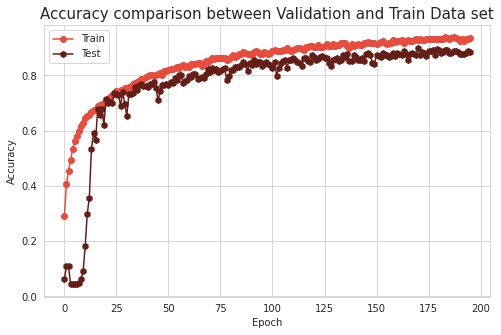

In [30]:
acc_plot(history)

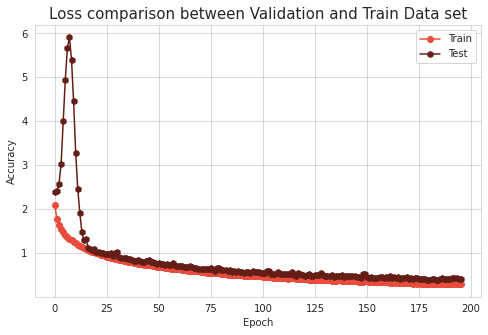

In [31]:
loss_plot(history)

In [32]:
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1) #Getting predicted labels
y_trues = np.argmax(y_test_encoded, axis=1)

In [33]:
cm = confusion_matrix(y_trues, yhat_probs)
cm

array([[199,   0,  11,   1,   0,   5,   0,   0,   0,   2],
       [  1,  67,   0,   4,   3,   0,   0,   3,   0,   2],
       [  6,   0, 169,   5,   0,   3,   0,   0,   4,   4],
       [  0,  16,  10, 152,   1,   3,   0,   2,   0,   1],
       [  1,   7,   2,   2, 153,   1,   0,  11,   0,   2],
       [  0,   0,   5,   1,   0, 188,   0,   1,   2,   0],
       [  0,   5,   0,   4,   2,   0,  67,   0,   0,   0],
       [  0,   2,   0,   1,   2,   1,   0, 156,   0,   3],
       [  0,   2,   5,  12,   0,   0,   0,   0, 170,   5],
       [  4,   2,  19,   4,   1,   2,   0,   1,   2, 130]])

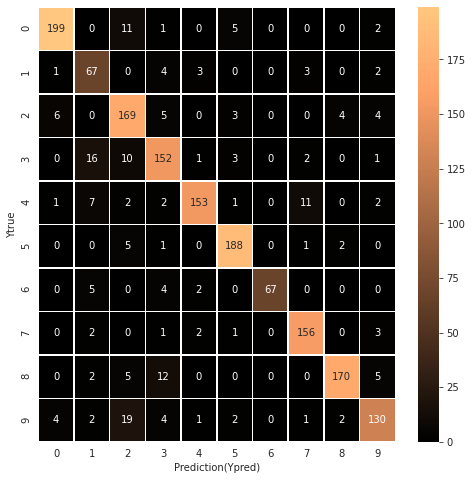

In [34]:
def display_cm():
  CM = confusion_matrix(y_trues, yhat_probs)
  f, ax = plt.subplots(figsize=(8,8))
  sb.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.copper)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()
display_cm()

In [35]:
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)
print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.94      0.91      0.93       218
        Car Horn       0.66      0.84      0.74        80
Children Playing       0.76      0.88      0.82       191
        Dog bark       0.82      0.82      0.82       185
        Drilling       0.94      0.85      0.90       179
   Engine Idling       0.93      0.95      0.94       197
        Gun Shot       1.00      0.86      0.92        78
      Jackhammer       0.90      0.95      0.92       165
           Siren       0.96      0.88      0.91       194
    Street Music       0.87      0.79      0.83       165

        accuracy                           0.88      1652
       macro avg       0.88      0.87      0.87      1652
    weighted avg       0.89      0.88      0.88      1652



In [36]:
accuracies = acc_per_class(cm)
pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
5,Engine Idling,95.431472
7,Jackhammer,94.545455
0,Air Conditioner,91.284404
2,Children Playing,88.481675
8,Siren,87.628866
6,Gun Shot,85.897436
4,Drilling,85.474860
1,Car Horn,83.750000
3,Dog bark,82.162162
9,Street Music,78.787879
